<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/wamp_slope_range(min_to_0_01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from scipy.ndimage.filters import uniform_filter as uf
from scipy.optimize import least_squares


import glob

fpath = os.path.join("drive", "My Drive", "lwir", "output")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define 4 pop model

In [ ]:
# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

In [ ]:
# -- read temp and humidity data
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "temp_humidity.csv")
temp = pd.read_csv(tname)

In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [ ]:
# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off


In [ ]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# Get time series data for each camera each day

In [ ]:
# -- read the outliers have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

In [ ]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

li = []
cnum = []

for filename in all_files:
  valid = True
  for b_id in bind:
    if (str(b_id) in filename):
      valid = False
      break
  if valid:
    df = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    li.append(df)
    cnum.append(cum)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
# -- create day and time column
frame["day"] = frame["date"].dt.date
frame["time"] = frame["date"].dt.time

In [ ]:
# -- get available date data
day = frame.groupby("day").count().reset_index()

In [ ]:
# -- groupby day and get the values
ff1a = frame.groupby("time")

avg_frame = []
for ind, gp in ff1a:
  avg_frame.append(gp["count"].values)

In [ ]:
# -- replace nans to nearest average counts
avg_frame = pd.DataFrame(avg_frame)
fnan = avg_frame.ffill()
bnan = avg_frame.bfill()
avg_count = 0.5*(fnan + bnan).T

In [ ]:
# -- add date for groupby
def new_sratio(sratio):
  sratio_day = []
  for index, row in sratio.iterrows():
   
    day_index = index % 31
    new_row = []
    new_row.append(row["sratio"])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each sratio
    sratio_day.append(new_row)

  return sratio_day

# 1a. For a given day, calculate the sratio for each camera and average.

In [ ]:
# -- transfer to dataframe 
avg_la = pd.DataFrame(avg_count)


cam_avg = []
for i in range(115):
  if i == 0:
    avg_cam = avg_la.iloc[0:31].mean()
  else:
    ii = i * 31
    jj = ii + 31
    avg_cam = avg_la.iloc[ii:jj].mean()
  cam_avg.append(avg_cam)
  
cam_avg = pd.DataFrame(cam_avg)

In [ ]:
cam_avg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.206843,0.152395,0.155820,0.119001,0.160426,0.179314,0.157666,0.101357,0.097496,0.100147,0.062708,0.095590,0.071396,0.099733,0.086548,0.088540,0.069968,0.063978,0.061144,0.091984,0.195831,0.351068,0.634112,0.960279,1.575852,2.555632,2.997086,3.504606,3.768899,4.482329,5.252902,6.330326,6.775432,7.789087,8.727946,8.979498,8.736266,7.494443,6.851353,6.570299,...,9.684206,9.595011,9.765381,9.754489,9.483301,10.004106,9.576197,9.653985,9.947195,9.289150,9.441054,9.319225,9.975884,9.697380,10.056576,9.941112,9.518429,9.186014,9.207378,9.094150,9.099319,7.444139,6.718558,5.600916,4.464452,3.490383,2.447737,1.156989,0.964965,0.774098,0.746432,0.630683,0.583112,0.511584,0.377269,0.440996,0.308471,0.230841,0.227630,0.251320
1,0.575607,0.552128,0.510565,0.479472,0.358023,0.301309,0.310546,0.315757,0.248515,0.243609,0.219177,0.168885,0.145970,0.176367,0.159245,0.174919,0.187304,0.220712,0.184897,0.390920,0.505376,0.588898,0.598064,0.801338,1.195308,1.702083,2.010640,2.182401,2.300432,2.661290,3.160670,3.572776,4.153602,4.947947,5.538886,5.788123,5.682596,5.384008,4.809662,4.716927,...,6.212493,5.956256,5.724506,5.218629,5.480938,5.770706,5.691161,5.851075,6.320681,6.389883,6.456452,6.816199,7.648222,8.140762,8.723851,8.694000,8.993928,8.937101,8.889063,8.601192,8.733345,8.560730,7.539462,6.943689,6.716625,5.889495,4.151613,2.429596,1.723137,1.625276,1.539326,1.351019,1.402803,1.315445,1.222513,1.087313,1.032502,0.869035,0.741691,0.841642
2,0.768731,0.795665,0.702966,0.649041,0.581078,0.463248,0.460110,0.372348,0.300534,0.324592,0.416861,0.415200,0.480487,0.368734,0.395045,0.377498,0.466937,0.385232,0.410411,0.438435,0.569013,0.691635,1.089811,1.616325,1.828837,2.289853,2.848718,3.436142,3.653564,4.178378,4.711031,5.729961,5.943161,6.785040,7.420250,7.762971,7.529889,7.218776,6.717005,6.614670,...,7.732799,6.809873,7.502933,7.840988,7.536250,7.627215,7.578664,8.073314,8.033654,7.855572,7.591333,8.294140,9.303756,9.869565,9.933160,9.888507,10.366520,9.609914,9.020242,8.713448,8.683469,7.369438,6.787680,5.816546,5.175197,3.879432,2.521163,1.934886,2.182348,2.151346,2.053845,2.002568,1.890242,1.808316,1.980243,1.690056,1.656647,1.659373,1.465640,1.442522
3,0.477814,0.451075,0.386371,0.361211,0.357249,0.305756,0.223964,0.241259,0.180709,0.187161,0.229585,0.194736,0.202816,0.169975,0.205113,0.183360,0.208568,0.190014,0.191466,0.178228,0.231055,0.270532,0.430769,0.599575,0.827837,1.255470,1.535604,1.715731,1.641984,2.035059,2.226701,2.273791,2.500617,3.124709,3.432281,3.688999,3.795943,3.834744,4.084439,3.878780,...,4.717278,4.593308,4.634064,4.441369,4.623086,4.959810,5.101857,5.051850,5.078483,4.848289,4.577243,4.550060,4.516734,5.086559,5.495752,5.447530,5.847046,5.549455,5.091513,5.057783,5.259358,4.883345,4.198902,3.189457,2.653372,2.419697,1.890875,1.446758,1.343580,1.323234,1.329074,1.185213,1.030717,1.028336,1.009001,0.926077,0.839116,0.738123,0.757580,0.614516
4,1.071712,0.822175,0.756260,0.580318,0.411407,0.384332,0.340360,0.316528,0.322919,0.251493,0.334666,0.333187,0.301846,0.296797,0.302861,0.309238,0.368298,0.372727,0.385777,0.368840,0.407576,0.608888,0.723869,1.208023,1.274242,2.067975,2.380314,3.704245,3.604000,4.906422,6.036657,7.132307,7.824397,8.842105,10.042067,10.874069,9.796079,9.761104,8.803406,8.341241,...,9.020430,8.359726,8.301970,8.963759,9.130417,9.908352,10.137213,10.232405,10.129323,10.464370,10.865103,10.623808,11.887037,11.280938,11.625085,11.260523,11.595327,11.093936,10.604912,10.598165,9.725321,9.081863,8.929686,7.843456,7.200135,6.176816,5.121475,3.989695,3.698267,3.725885,3.333026,3.167306,2.858255,2.690334,2.459185,2.263533,2.325024,1.870945,1.795797,1.420870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]
# -- optimize
plsq = []
for ii in range(len(cam_avg)):
  #print("working on day {0}".format(ii))

  plsq.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, cam_avg.iloc[ii])))

In [ ]:
# -- put fit results into DataFrame
result_1a = pd.DataFrame(plsq)["x"].values

df1a = pd.DataFrame(np.vstack(result_1a), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

In [ ]:
df1a

,m1,m2,m3,sd1,sd2,sd3,scl1,scl2,scl3,wamp,off
0,33.882000,52.919443,71.175768,5.386676,8.000000,6.804779,95.542189,171.860963,140.790605,0.003114,-0.227798
1,34.283515,52.345674,73.562252,5.200769,6.472049,6.127689,49.862864,57.967277,92.620052,0.007360,-0.256308
2,33.401580,50.806433,71.544989,5.563929,3.725445,4.079011,63.182413,28.140196,31.700611,0.016010,-0.815392
3,34.290481,51.126590,73.321736,8.000000,3.123648,2.838184,34.486094,5.413282,7.693194,0.011077,-0.756651
4,34.179661,47.945110,70.330383,4.431890,4.383096,8.000000,76.477538,38.160706,74.839682,0.017266,-0.755383
...,...,...,...,...,...,...,...,...,...,...,...
110,32.914167,49.356008,69.999524,5.124682,8.000000,7.432742,18.434227,20.752561,37.339238,0.000873,-0.010903
111,29.206200,44.000000,76.446667,5.807806,5.740698,8.000000,13.920181,12.753184,17.342417,0.003149,0.153236
112,32.484992,47.670336,80.000000,5.280084,3.101845,8.000000,14.587495,3.030603,10.806896,0.006780,-0.114004
113,33.737306,51.760271,69.550016,5.292918,7.041344,7.070082,75.636135,113.497392,111.307624,0.002690,0.285397


Text(0.5, 1.0, 'scl2 vs wamp')

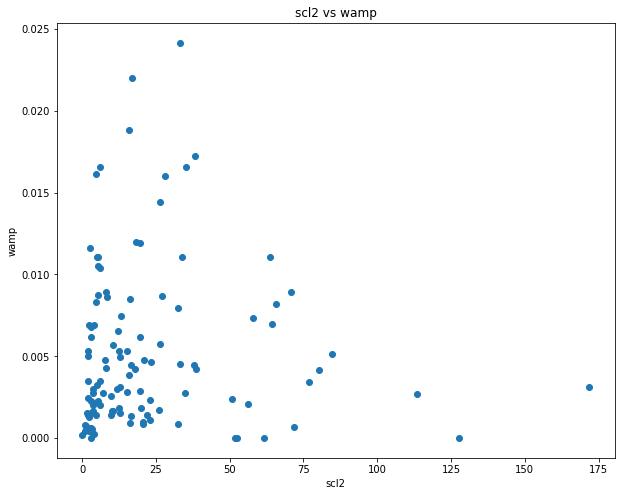

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(df1a["scl2"], df1a["wamp"])
plt.xlabel("scl2")
plt.ylabel("wamp")

plt.title("scl2 vs wamp")

# Get the dropped camera ID

In [ ]:
# -- add camera number
df1a["cnum"] = cnum
import re
import statsmodels.formula.api as sm

In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

# -- read cam id for outliers that have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

In [ ]:
# -- define add date

def add_date(count):
  count_day = []
  for index, row in count.iterrows():
   
    day_index = index % 31
    new_row = []
    for i in range(len(row)):
      new_row.append(row[i])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each row
    count_day.append(new_row)

  return count_day

In [ ]:
coefs = []
wcuts = np.linspace(2.262652182169483e-34, 0.010, 50)
camid = []
for wcut in wcuts:
# -- select cams with wamp < wcut

  drop_cam = df1a[df1a["wamp"] > wcut]
  # drop_cam = drop_camera[drop_camera["wamp"] > 0.010]
  dcnum = drop_cam["cnum"]
  # -- keep only numeric
  dcnum = pd.DataFrame(dcnum)
  bad_camera = []
  for v in dcnum.values.tolist():
    bad_camera.append(int(v.pop().split(".")[0]))
    final_bad_cam = list(set(bind + bad_camera))
    
  # -- read multi_files and combine them together
  path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
  all_files = glob.glob(path + "/*.feather")

  cam = []
  num = []

  for filename in all_files:
    valid = True
    for b_id in final_bad_cam:
      if (str(b_id) in filename):
        valid = False
        break
    if valid:
      df0 = pd.read_feather(filename)
      cum = filename.split("_")[-1].split("_")[0]
      cam.append(df0)
      num.append(cum)

  frame_drop = pd.concat(cam, axis=0, ignore_index=True)
  # -- create day and time column
  frame_drop["day"] = frame_drop["date"].dt.date
  frame_drop["time"] = frame_drop["date"].dt.time
  # -- get available date data
  day_drop = frame_drop.groupby("day").count().reset_index()  
  # -- groupby day and get the values

  fft = frame_drop.groupby("time")

  avg_frame_drop = []
  for ind, gp in fft:
    avg_frame_drop.append(gp["count"].values)

  # -- replace nans to nearest average counts
  avg_frame_drop = pd.DataFrame(avg_frame_drop)
  fnan_drop = avg_frame_drop.ffill()
  bnan_drop = avg_frame_drop.bfill()
  avg_count_drop = 0.5*(fnan_drop + bnan_drop).T

  # -- get the counts
  avg_2b = avg_count_drop.values.copy()

  # -- standardized data
  avg_2b_m = avg_2b.mean(axis=1, keepdims=True)
  avg_2b_std = avg_2b.std(axis=1, keepdims=True)
  avg_2b_st = (avg_2b - avg_2b_m) / (avg_2b_std + (avg_2b_std == 0))
  avg_2b_st = pd.DataFrame(avg_2b_st)

  # -- get available date data
  day = frame.groupby("day").count().reset_index()

  # -- add date for st counts
  avg_2b_date = pd.DataFrame(add_date(avg_2b_st))

  # -- rename dataframe 96 to day
  avg_2b_date = avg_2b_date.rename(columns = {96:'day'})

  # -- get avg_st counts
  avg_std_date = avg_2b_date.groupby("day").mean()

  # -- optimize
  wendvals = weekend
  xval_final = np.arange(96)
  bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
  bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

  plsq_2b = []
  for ii in range(len(avg_std_date)):
    plsq_2b.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                              args=(xval_final, avg_std_date.iloc[ii])))
    
  # -- put fit results into DataFrame
  result_2b = pd.DataFrame(plsq_2b)["x"].values
  df2b = pd.DataFrame(np.vstack(result_2b), 
                      columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])
  # -- calculate sratio 
  df2b["sratio"] = df2b["scl2"] / (0.5 * (df2b["scl1"] + df2b["scl3"]))
  # -- add date column
  sratio_2b = pd.DataFrame(new_sratio(df2b))
  sratio_2b["wamp"] = df2b["wamp"]
  sratio_2b["scl1"] = df2b["scl1"]
  sratio_2b["scl2"] = df2b["scl2"]
  sratio_2b["scl3"] = df2b["scl3"]
  sratio_2b.columns = ["sratio", "date", "wamp", "scl1", "scl2", "scl3"]
  # -- subset humidity and temp to our research period
  sratio_2b["date"] = sratio_2b["date"].astype(str)
  temp_day_2b = sratio_2b.merge(temp, left_on="date", right_on="day")
  
  # -- first build the model
  model = sm.ols("sratio ~ temp", data=temp_day_2b)

  # -- now fit the model to the data
  result = model.fit()
  coefs.append(result.params[1])
  camid.append(num)


In [ ]:
camid = pd.DataFrame(camid)
coefs = pd.DataFrame(coefs)
wcuts = pd.DataFrame(wcuts)
coef_wcut = wcuts.copy()
coef_wcut["coefs"] = coefs
coef_wcut.columns=["wcut", "coefs"]

In [ ]:
coef_wcut

,wcut,coefs
0,2.262652e-34,-0.022094
1,2.040816e-04,0.027593
2,4.081633e-04,0.001633
3,6.122449e-04,-0.002897
4,8.163265e-04,-0.011724
5,1.020408e-03,-0.019606
6,1.224490e-03,-0.025429
7,1.428571e-03,-0.028608
8,1.632653e-03,-0.026846
9,1.836735e-03,-0.028219


In [ ]:
coef_wcut
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "wamp_0001cut.csv")
coef_wcut.to_csv(oname, index=False)

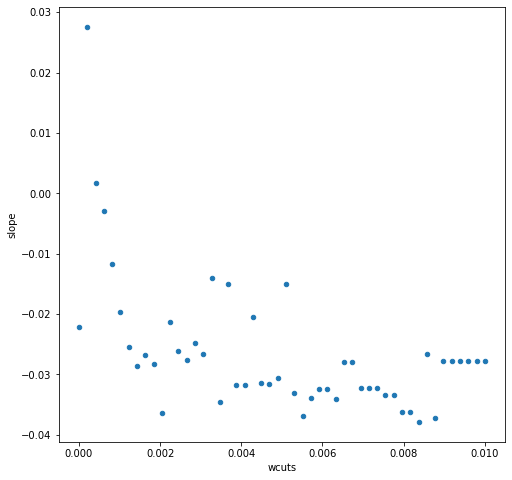

In [ ]:
import matplotlib.pyplot as plt


coef_wcut.plot.scatter("wcut", "coefs", figsize=[8, 8])
plt.xlabel("wcuts")
plt.ylabel("slope")
outfile = os.path.join("drive", "My Drive", "lwir", "output",
                       "wamp_slop_0.01).png")
plt.savefig(outfile)

Get the dropped camera ID

In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

In [ ]:
# -- get the lat/lon of the good cameras
camera["cam_id"] = camera["cam_id"].astype(str)
cam_id = camera.merge(id, left_on="cam_id", right_on="id")
cam_id

In [ ]:
# -- plotting 

try:
  import geopandas as gp
except:
  !pip install geopandas


fig = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
# -- plot it
#    (Borough geojson from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]
# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"
# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camera.lon, camera.lat, color="green", label='Camera Location')
ax.scatter(cam_id.lon, cam_id.lat, marker="x", color="red", label='Camera0')
ax.scatter(cam_id.lon, cam_id.lat, marker="o", color="yellow", label='Camera1')

ax.legend(loc='upper left')
